In [2]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import Exercise_6 as ex6
import tools as tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 6: Gaussian Shock

Consider the model
$$\begin{align*}
V_{t}(W_{t}) & = & \max_{C_{t}}\left\{ \frac{C_{t}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[V_{t+1}(W_{t+1})\right]\right\} \\
 & \text{s.t.}\\
W_{t+1} & = & R(W_{t}-C_{t})+Y_{t+1}\\
Y_{t+1} & = & \exp(\xi_{t+1})\\
\xi_{t+1} & = & \mathcal{N}(0,\sigma_{\xi}^{2})\\
A_{t}=W_{t}-C_{t} & \geq & 0
\end{align*}$$

for $T=10$, $\beta=0.98$, $\rho=0.5$, $R=1.0/\beta$, $W_1=10$ and $\sigma_{\xi}=0.2$.

### 1. Solve it using Gauss-Hermite quadrature for evaluating the expectation. 

In [7]:
# Setup specifications in class. 
class par: pass
par.beta = 0.98
par.rho = 0.5
par.R = 1.0/par.beta
par.sigma = 0.2
par.mu = 0
par.W = 10
par.T = 10
par.num_shocks = 5

#Gauss-Hermite nodes and transformation
x,w = tools.gauss_hermite(par.num_shocks)
par.eps = np.exp(par.sigma*np.sqrt(2)*x) #Change of variable
par.eps_w = w/np.sqrt(np.pi) #Corresponding weights

# Grid
par.num_W = 200
par.num_C = 200

# Solve the model
sol = ex6.solve_consumption_deaton(par)

### 2. Plot the consumption function and the value function. See how the optimal consumption and value function varies over time.

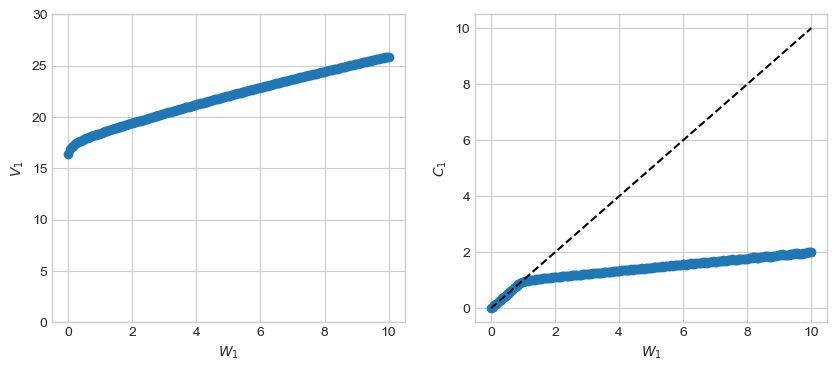

In [8]:
# Define a function for the solution
def plot_solution(sol,par,t):
    fig = plt.figure(figsize=(10,4))# figsize is in inches...
    
    ax = fig.add_subplot(1,2,1)
    ax.scatter(sol.grid_W[:,t],sol.V[:,t])
    ax.set_xlabel(f"$W_{t+1}$")
    ax.set_ylabel(f"$V_{t+1}$")
    ax.set_ylim(0,30)

    ax_right = fig.add_subplot(1,2,2)
    ax_right.scatter(sol.grid_W[:,t],sol.C[:,t])
    ax_right.plot(sol.grid_W[:,t],sol.grid_W[:,t],color='black',linestyle='dashed')
    ax_right.set_xlabel(f"$W_{t+1}$")
    ax_right.set_ylabel(f"$C_{t+1}$")

    plt.show()

plot_solution(sol,par,0)

### 3. Simulate a panel of *N* household for *T* periods and plot the mean of $C_t$. Everybody should be initialized with $W_t = 1.5$. Compare a simulation where $\sigma_{\xi}=0.2$ and $\sigma_{\xi}=0$. What happens to consumption over time in the two simulations?

In [ ]:
# set-up
par.simN = 10000
par.W_ini = 1.5

# Create a copy of the class
class par_sigma_0(par): pass  
par_sigma_0.sigma = 0 
x,w = tools.gauss_hermite(par_sigma_0.num_shocks)
par_sigma_0.eps = np.exp(par_sigma_0.sigma*np.sqrt(2)*x)
par_sigma_0.eps_w = w/np.sqrt(np.pi)


def simulate(sol, par):
    # Allocate
    class sim: pass
    shape = (par.simN, par.T)
    sim.W = par.W_ini*np.ones(shape)
    sim.C = np.nan +np.zeros(shape)
    
    # Simulate 
    np.random.seed(2022) #Seed value, it ensures that the computer draw the same "random"-numbers each time
    
    for t in range(par.T):
        
        
        # fill in
    
    return sim


# Simulation for sigma=0
sol_sigma_0 = ex6.solve_consumption_deaton(par_sigma_0)
sim_sigma_0 = simulate(sol_sigma_0,par_sigma_0)
sim_C_sigma_0 = np.mean(sim_sigma_0.C, axis=0) #Mean over individuals
sim_W_sigma_0 = np.mean(sim_sigma_0.W, axis=0) #Mean over individuals


# Simulation for sigma=0.2
sim = simulate(sol,par)
sim_C = np.mean(sim.C, axis=0) #Mean over individuals
sim_W = np.mean(sim.W, axis=0) #Mean over individuals

#Plot
fig = plt.figure(figsize=(10,4))# figsize is in inches...
    
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(1,par_sigma_0.T+1),sim_C_sigma_0, label='$\sigma = 0$')
ax1.plot(range(1,par.T+1),sim_C, label='$\sigma = 0.2$')
ax1.set_ylabel('$C_t$')
ax1.set_xlabel('$t$')
ax1.set_title('Consumption')
ax1.set_ylim(0.5,1.5)
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(range(1,par_sigma_0.T+1),sim_W_sigma_0, label='$\sigma = 0$')
ax2.plot(range(1,par.T+1),sim_W, label='$\sigma = 0.2$')
ax2.set_ylabel('$W_t$')
ax2.set_xlabel('$t$')
ax2.set_title('Cash-in-hand')

### 4. Calculate the Euler-error 
The Euler-equation with uncertainty is given by
$$\begin{align*}
  u'(C_{i,t}) = \beta R E_t[u'(C_{i,t+1})]
\end{align*}$$

The Euler-error is the calculated as
$$\begin{align*}
  \varepsilon_{it} \approx u'(C_{it})-\beta R \sum_{j=1}^{S} \omega_j \Big[u'\big(C_{i,t+1}^{\star}(R(W_{it}-C_{it})+Y_j)\big)\Big]
 \end{align*}$$
 and $\omega_j$ are the Gauss-Hermite weights and $Y_j$ are the associated income nodes.

The mean Euler-error is given by
$$\begin{align*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T}  \mathbb{1}_{\{0<C_{it}<W_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_{it}<W_{it}\}} |\varepsilon_{it}|
 \end{align*}$$
where it must hold that $0<C_{it}<W_{it}$. If $C_{it}=W_{it}$  agents are credit constrained and the Euler equation doesn't hold.

In [ ]:
# Define the marginal utility
def marg_util(C,par):
    y = C**(-par.rho)
    return y


# 1. Solve the model
sol = ex6.solve_consumption_deaton(par)

# 2. simulate
sim = simulate(sol,par)

# 3. Calculate the Euler residual
Euler_residual = np.nan + np.zeros((par.simN,par.T-1))  # Allocate space
A = np.nan + np.zeros((par.simN,par.T-1))               # Allocate space


for t in range(par.T-1):   # Sum over t (and the sum over N happens in vector notation)
    
    # Initialize
    w = sim.W[:,t]
    c = sim.C[:,t]
    w_c = w-c
    A[:,t] = w_c 
    
    marg_util_next = 0

    for s in range(par.num_shocks):
                    # fill in
                    # Hint: Calculate expectations with loop
            
            
            
            
            
                    
    Euler_residual[:,t] = marg_util(c,par)-par.beta*par.R*marg_util_next

# 4. Calculate the average absolute euler residual
I = (A>0)   # Only evaluate at the interior solution
Euler_error = np.mean(abs(Euler_residual[I]))


print(f'The Euler error:    {Euler_error:.4f}')

### 7. Likewise calculate the normalized Euler-error


$$\begin{align*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_1<W_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} log_{10}(|\varepsilon_{it}| / C_{it}) \mathbb{1}_{0<C_1<W_{it}} 
 \end{align*}$$

and discuss what this implies for the accuracy of the solution.

In [ ]:
C =(sim.C[:,0:par.T-1])  # The euler error is not defined in last period

nom_Euler_error = np.log10(abs(Euler_residual[I])/(C[I]))   
nom_Euler_error = np.mean(nom_Euler_error)


print(f'The Normalized Euler error:    {nom_Euler_error:.4f}')

### 8. Look at how the Euler-errors change when you vary the number of grid points. 

In [ ]:
# Define functions

#Function for Setup
def setup():
    class par: pass
    par.beta = 0.98
    par.rho = 0.5
    par.R = 1.0/par.beta
    par.sigma = 0.2
    par.mu = 0
    par.W = 50
    par.T = 10
    
    par.num_shocks = 5
    x,w = tools.gauss_hermite(par.num_shocks)
    par.eps = np.exp(par.sigma*np.sqrt(2)*x)
    par.eps_w = w/np.sqrt(np.pi)
    
    # Grid
    par.num_W = 200
    par.num_C = 200

    # Simulation parameters
    par.simN = 10000
    par.W_ini = 1.5
    
    return par

#Function for Euler Error
def Euler_error(par, sol, sim):
    Euler_residual = np.nan + np.zeros((par.simN,par.T-1))  # Allocate space
    A = np.nan + np.zeros((par.simN,par.T-1))               # Allocate space
    
    for t in range(par.T-1):   # Sum over t (and the sum over N happens in vector notation)
        
        # Initialize
        w = sim.W[:,t]
        c = sim.C[:,t]
        w_c = w-c
        A[:,t] = w_c 
        
        marg_util_next = 0
    
        for s in range(par.num_shocks):
                        # fill in
                
                
                        
                        
        Euler_residual[:,t] = marg_util(c,par)-par.beta*par.R*marg_util_next
    
    
    I = (A>0)   
    Euler_error = np.mean(abs(Euler_residual[I]))
    
    C =(sim.C[:,0:par.T-1])

    nom_Euler_error = np.log10(abs(Euler_residual[I])/(C[I]))   
    nom_Euler_error = np.mean(nom_Euler_error)
    
    print(f'Number of grid points:         {par.num_W} ')
    print(f'The Euler error:               {Euler_error:.4f}')
    print(f'The Normalized Euler error:    {nom_Euler_error:.4f}', end ='\n\n')

In [ ]:
# Find the Euler Error for different grid points

#Array of grid points    
grid_points = np.array([10,20,40,50,70,100,1000])

for i,grid_point in enumerate(grid_points):
    # setup
    pars = setup()
    pars.num_W = grid_point
    
    # solve
    sols = ex6.solve_consumption_deaton(pars)


    # simulate
    sims = simulate(sol, pars)

    # calculate the errors
    Euler_error(pars, sols, sims)